In [15]:
import pandas as pd
import numpy as np


from shapely.geometry import Point # 将pd数据（csv）转为gpd（shp）数据
import copy

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
print('pandas: %s'%pd.__version__)
print('numpy: %s'%np.__version__)

import shapely
print('shapely: %s'%shapely.__version__)

import matplotlib
print('geopandas: %s'%gpd.__version__)
print('matplotlib: %s'%matplotlib.__version__)
print('seaborn: %s'%sns.__version__)

pandas: 1.0.3
numpy: 1.18.2
shapely: 1.6.4.post1
geopandas: 0.6.2
matplotlib: 3.0.3
seaborn: 0.10.0


In [17]:
def df2gdf(df):
    
    '''
    将pd数据（csv）转为gpd（shp）数据
    '''
    geometry = [Point(xy) for xy in zip(df.zonex, df.zoney)]
    df = df.drop(['zonex', 'zoney'], axis=1)
    crs = {'init': 'epsg:4326'}
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    return gdf

--------

# 1 第一部分：读取数据量最少的E城市，查看单个城市情况
数据文件夹：train_data（**数据文件夹要和这个notebook要放在同一个根目录内**）

共5个城市

--------

## 1.1 grid_attr 网格归属区域

城市内网格对应的归属区域ID

网格中心经度，网格中心点纬度，归属区域ID

发现：

`网格人流量指数`和`网格归属区域`的总体经纬度范围不一致，`网格人流量指数`的范围大一些

```
min max
density
163.890253,165.620299
27.432226,28.940051

grid
164.122034,165.521567
27.620114,28.812079
```

因为`各区域每天新增感染人数`是以`网格归属区域`为基础采集数据的，因此后续处理以`网格归属区域`的范围为准

In [18]:
zone=pd.read_csv('train_data/city_E/grid_attr.csv',header=None,names=['zonex','zoney','zoneid'])

将zone按照id分组，其中共有34个区域，每个区域有100对经纬度点

In [19]:
zone.tail()

,zonex,zoney,zoneid
3395,165.521567,28.106786,33
3396,165.521567,28.108379,33
3397,165.521567,28.109972,33
3398,165.521567,28.111565,33
3399,165.521567,28.113158,33


In [20]:
zoneg=zone.groupby('zoneid') # zone按id分组

In [21]:
for i,g in zoneg:
    print('id: %2d, pointNum: %d, min: (%.6f,%.6f), max: (%.6f,%.6f)'%(i,len(g),g.zonex.min(),g.zoney.min(),g.zonex.max(),g.zoney.max()))

id:  0, pointNum: 100, min: (164.122034,27.971194), max: (164.138140,27.985829)
id:  1, pointNum: 100, min: (164.157867,27.812109), max: (164.174045,27.826526)
id:  2, pointNum: 100, min: (164.265664,27.620114), max: (164.281797,27.634676)
id:  3, pointNum: 100, min: (164.283594,27.620178), max: (164.299790,27.634684)
id:  4, pointNum: 100, min: (164.283594,27.636172), max: (164.299790,27.650685)
id:  5, pointNum: 100, min: (164.283621,28.051401), max: (164.299817,28.065850)
id:  6, pointNum: 100, min: (164.337681,28.050788), max: (164.353850,28.065172)
id:  7, pointNum: 100, min: (164.337663,28.066726), max: (164.353850,28.081101)
id:  8, pointNum: 100, min: (164.337654,28.082655), max: (164.353832,28.097035)
id:  9, pointNum: 100, min: (164.355638,28.050844), max: (164.371763,28.065435)
id: 10, pointNum: 100, min: (164.481365,28.607300), max: (164.497480,28.621854)
id: 11, pointNum: 100, min: (164.678956,28.432677), max: (164.695197,28.447201)
id: 12, pointNum: 100, min: (164.678947,

--------

## 1.2 infection各区域每天新增感染人数
日期,区域ID,新增感染人数

34个检测站点，45天

In [22]:
ifc=pd.read_csv('train_data/city_E/infection.csv',header=None,names=['city','zoneid','date','ifc'])

In [23]:
ifc.tail()

,city,zoneid,date,ifc
1525,E,33,21200610,8
1526,E,33,21200611,4
1527,E,33,21200612,3
1528,E,33,21200613,7
1529,E,33,21200614,4


In [24]:
len(ifc.date.unique())

45

In [25]:
len(ifc.zoneid.unique())

34

In [26]:
len(ifc)

1530

In [27]:
45*34

1530

### pd转为np二维数组，45行（日期）34列（站点）

In [28]:
ifc_arr=np.array(ifc.set_index(['date','zoneid']).unstack()['ifc'])

In [29]:
ifc_arr.shape

(45, 34)

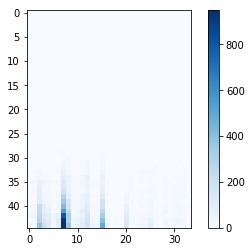

In [30]:
plt.imshow(ifc_arr, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

--------

## 1.3 density 网格人流量指数
日期，小时，网格中心点经度,网格中心点纬度,人流量指数

45天每周两天抽样数据

周一 周四

In [31]:
dst=pd.read_csv('train_data/city_E/density.csv',header=None,names=['date','hour','zonex','zoney','dst'])

In [32]:
dst.tail()

,date,hour,zonex,zoney,dst
11019367,21200613,9,165.607696,28.237820,0.2
11019368,21200613,9,165.607696,28.239411,0.2
11019369,21200613,9,165.609493,28.229856,0.9
11019370,21200613,9,165.609493,28.236221,0.2
11019371,21200613,9,165.611289,28.229848,0.1


### 选择第一天21200506（周一）的数据

In [33]:
dst1=dst[dst.date==21200506]

#### 按小时分类汇总

In [34]:
dst1.groupby('hour').dst.agg(['count','sum','mean'])

,count,sum,mean
hour,,,
0,27872,37909.6,1.360132
1,25343,27422.6,1.082058
2,25833,26676.3,1.032644
3,25846,25732.9,0.995624
4,25615,24421.0,0.953387
5,27917,28703.4,1.028169
6,36376,59202.3,1.627510
7,41883,92589.3,2.210665
8,44050,100794.0,2.288173


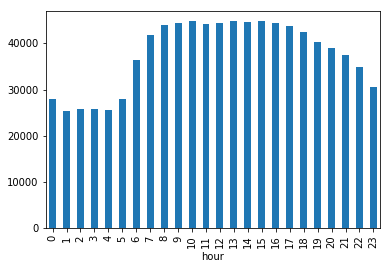

In [35]:
dst1.groupby('hour').dst.count().plot(kind='bar')

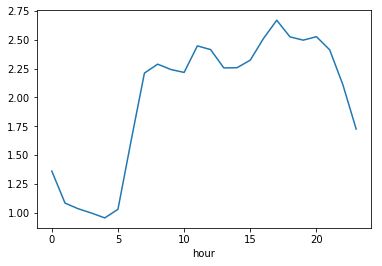

In [36]:
dst1.groupby('hour').dst.mean().plot()

### 选择这一天上午8点和下午17点的数据

In [37]:
dst108=dst1[(dst1.hour==8)&(dst1.dst<5)][['zonex','zoney','dst']]
dst117=dst1[(dst1.hour==17)&(dst1.dst<5)][['zonex','zoney','dst']]

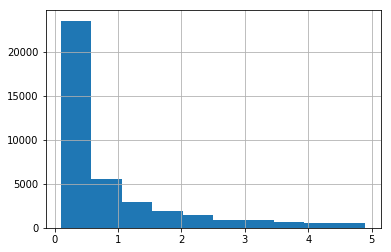

In [38]:
dst117.dst.hist()

### 空间分析

#### 将pd数据（csv）转为gpd（shp）数据

In [39]:
dst108_shp=df2gdf(dst108)
dst117_shp=df2gdf(dst117)

### plt + gpd 绘制散点图，密度越大颜色越深 

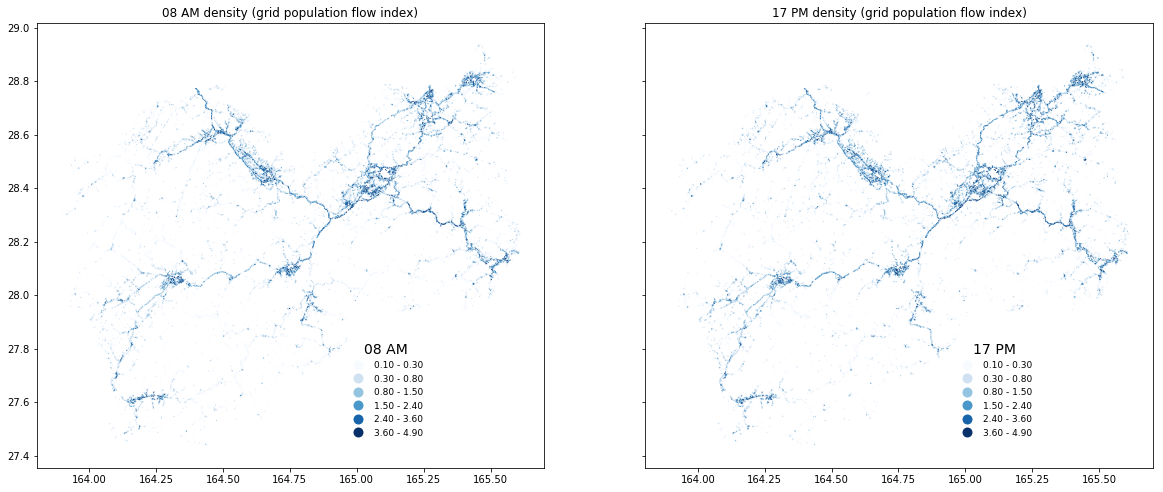

In [40]:
fig,(ax1,ax2)=plt.subplots(ncols=2,sharex=True,sharey=True,figsize=(20,10))
dst108_shp.plot(column='dst',ax=ax1,
                scheme='NaturalBreaks',k=6,legend=True,
                markersize=1,linewidth=0,cmap='Blues',
                legend_kwds={'bbox_to_anchor': (0.6,0.3),
                             'fontsize':9,
                             'frameon':False,
                             'title':'08 AM',
                             'title_fontsize':14
                            }
               )

dst117_shp.plot(column='dst',ax=ax2,
                scheme='NaturalBreaks',k=6,legend=True,
                markersize=1,linewidth=0,cmap='Blues',
                legend_kwds={'bbox_to_anchor': (0.6,0.3),
                             'fontsize':9,
                             'frameon':False,
                             'title':'17 PM',
                             'title_fontsize':14
                            }
               )
ax1.title.set_text('08 AM density (grid population flow index)')
ax2.title.set_text('17 PM density (grid population flow index)')

# ax1.axis('off')
# ax2.axis('off')
fig.savefig('21200506某小时网格人流量密度.png',dpi=300, bbox_inches='tight')
plt.show()

### 网格归属区域和网络人流量指数复合地图
网格人流量指数从点数据转为shp地理数据文件

In [41]:
zone_shp=df2gdf(zone)

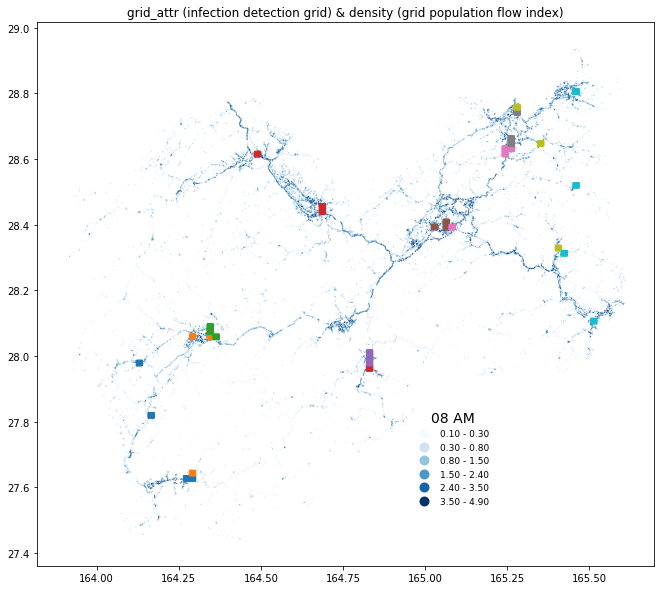

In [42]:
fig,ax1=plt.subplots(ncols=1,sharex=True,sharey=True,figsize=(20,10))
dst108_shp.plot(column='dst',ax=ax1,
                scheme='NaturalBreaks',k=6,legend=True,
                markersize=1,linewidth=0,cmap='Blues',
                legend_kwds={'bbox_to_anchor': (0.6,0.3),
                             'fontsize':9,
                             'frameon':False,
                             'title':'08 AM',
                             'title_fontsize':14
                            }
               )
zone_shp.plot(column='zoneid',ax=ax1,markersize=1,categorical=True,k=34)
ax1.title.set_text('grid_attr (infection detection grid) & density (grid population flow index)')

fig.savefig('网格归属区域和网络人流量指数复合地图.png',dpi=300, bbox_inches='tight')
plt.show()

--------

## 1.4 migration 城市间迁徙指数 
迁徙日期,迁徙出发城市,迁徙到达城市,迁徙指数

45天

In [43]:
mgr=pd.read_csv('train_data/city_E/migration.csv',header=None,names=['date','city1','city2','mgr'])

In [44]:
mgr.tail()

,date,city1,city2,mgr
355,21200614,D,E,0.089003
356,21200614,E,A,0.057024
357,21200614,E,B,0.003240
358,21200614,E,C,0.075557
359,21200614,E,D,0.090947


--------

## 1.5 transfer 网格关联强度
城市内网格间关联强度数据

小时，出发网格中心点经度， 出发网格中心点纬度， 到达网格中心点经度， 到达网格中心点纬度， 迁移强度

In [45]:
tsf=pd.read_csv('train_data/city_E/transfer.csv',header=None,names=['hour','zone1x','zone1y','zone2x','zone2y','tsf'])

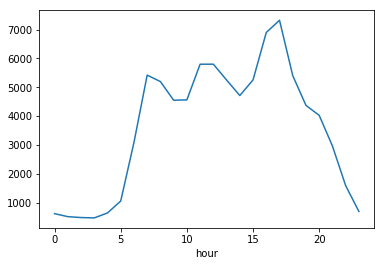

In [46]:
tsf.groupby('hour')['tsf'].sum().plot()

简单求和后看起来7点和17点的网络关联强度最大

--------

## 1.6 weather 天气数据
45天每天数据

日期 小时 气温 湿度 风向 风速 风力 天气

date, hour, temperature, humidity, wind direction, wind speed, wind force, weather

In [47]:
wea=pd.read_csv('train_data/city_E/weather.csv',header=None,names=['date','hour','tmp','hmd','wdd','wdv','wdf','wea'])

In [48]:
wea.tail()

,date,hour,tmp,hmd,wdd,wdv,wdf,wea
1075,21200614,19,7,NaN,Southeast,NaN,<3,Overcast
1076,21200614,20,14,76%,Southeast,<12km/h,1,Cloudy
1077,21200614,21,10,81%,Quiet,NaN,0,Sunny
1078,21200614,22,13,82%,East,<12km/h,1,Cloudy
1079,21200614,23,7,NaN,Southeast,NaN,<3,Overcast


--------

# 2 第二部分：合并5个城市的infection和migrant表格，查看总体情况

--------

## 2.1 遍历读取5个城市的infection数据+合并

In [49]:
ifc=pd.DataFrame([],columns=['city','zoneid','date','ifc'])
for city in list('ABCDE'):
    ifc=pd.concat([ifc,pd.read_csv('train_data/city_%s/infection.csv'%city,header=None,names=['city','zoneid','date','ifc'])])

|city|date|station|size|
|---|---|---|---|
|A|45|118|5310|
|B|45|30|1350|
|C|45|135|6075|
|D|45|75|3375|
|E|45|34|1530|

### 分析5个城市的新增感染人数，绘制时间序列变化曲线

In [50]:
ifc1=ifc.groupby(['city','date'])[['ifc']].sum().reset_index() # 分组，求新增感染人数总和

In [51]:
ifc1['date']=pd.to_datetime(ifc1['date'],format='%Y%m%d') # 日期格式转化

#### (1)分开绘制

city
A    AxesSubplot(0.125,0.125;0.775x0.755)
B    AxesSubplot(0.125,0.125;0.775x0.755)
C    AxesSubplot(0.125,0.125;0.775x0.755)
D    AxesSubplot(0.125,0.125;0.775x0.755)
E    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

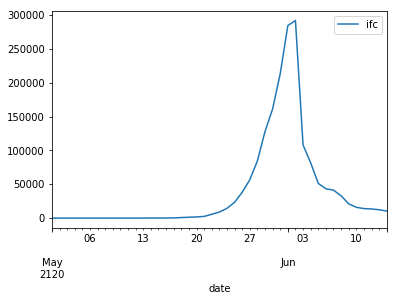

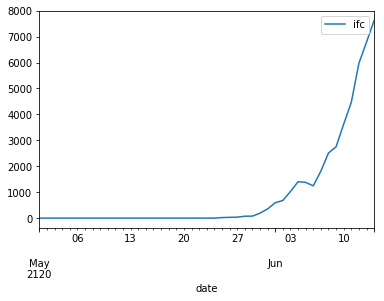

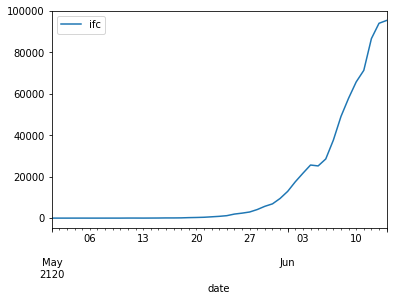

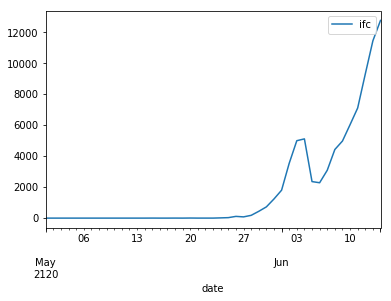

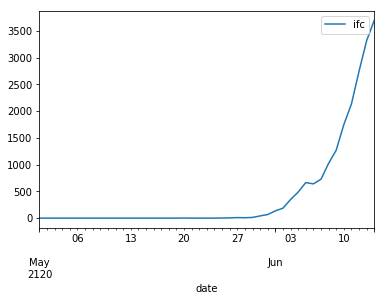

In [52]:
ifc1.groupby('city').plot(x='date',y='ifc')

#### (2)5个都绘制在一张图上

In [53]:
ifc2=ifc1.set_index(['date','city']).unstack().reset_index()

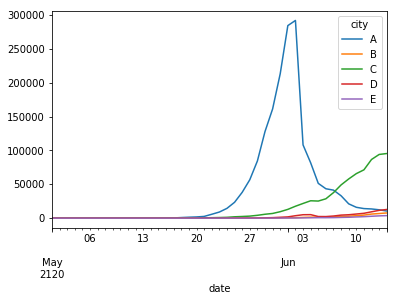

In [54]:
ifc2.plot(x='date',y='ifc')

分析: A已经控制住疫情，C快要爆发，BDE还很少

### 把infection的数据格式转为论文的二维数表: 将长数据转为宽数据
先看城市A和C的

In [55]:
arra=np.array(ifc[ifc.city=='A'].drop(columns='city').set_index(['date','zoneid']).unstack())
arrc=np.array(ifc[ifc.city=='C'].drop(columns='city').set_index(['date','zoneid']).unstack())

In [56]:
arra.shape #45天 118个监测站 

(45, 118)

In [57]:
ifc[ifc.city=='A'].drop(columns='city').set_index(['date','zoneid']).unstack()

ifc                                                 ...             \
zoneid    0    1    2    3     4    5    6    7    8     9    ...   108  109   
date                                                          ...              
21200501    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200502    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200503    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200504    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200505    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200506    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200507    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200508    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200509    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200510    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200511    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200512    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200513    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200514    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200515    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200516    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200517    0    0    0    0     0    0    0    0    0     0  ...     0    0   
21200518    0    0    0    0     0    0    0    0    0     0  ...     4    0   
21200519    0    0    0    0     0    0    0    0    0     0  ...     3    0   
21200520    0    0    0    0     4    0    0    0    0     1  ...     0    4   
21200521    0    1    0    0     8    0    0   10    2     0  ...     8    7   
21200522    0    1    0    0    32    0    1    0    5     0  ...    27    1   
21200523    0    2    0    1     1    0    3    1   16     4  ...   140    2   
21200524    0    5    7    4     0    2    2   10    5    31  ...   157    6   
21200525    0    9    7    4    82    2    0   39   24    38  ...   149   53   
21200526    1   28   12   20   217    2    5   36   20   106  ...   289   49   
21200527   19   62   21   12   207   11    5   64   27   113  ...   765  163   
21200528   33  103   26   21   223   12   40  152   52   211  ...  1374  193   
21200529   41  128   75   41   375   31   60  197   90   420  ...  2186  331   
21200530   59  259  162   85   134   55   59  155   81   618  ...  3384  479   
21200531   63  311  154   95  1032   48   67  263  124   814  ...  3890  471   
21200601  163  541  198  121  1221   71  115  387  191  1075  ...  4719  474   
21200602  420  823  327  141  1300  115  170  336  252  1085  ...  5449  409   
21200603  165  449  148   82   102   52   89  144  115   438  ...  2056  155   
21200604  189  525  194   69    86   61  110   93  118   357  ...  1639  135   
21200605  156  228  125   75    60   91   61  118   73   289  ...   876  122   
21200606   46  184  124   60    35   78   50  116   74   276  ...   723   91   
21200607   84  229  142   48    25  111   39  115   77   279  ...   635   92   
21200608   75  152  108   53    40   99   54  100   65   208  ...   578   61   
21200609   48  136   65   25    22   72   49   60   53   164  ...   330   51   
21200610   36   96   43   31    13   48   36   43   50   145  ...   237   35   
21200611   60  107   43   22    13   57   20   63   18   151  ...   202   22   
21200612   29   68   57   14     6   47   10   70   49   138  ...   191   53   
21200613   38  104   40   10     4   49   23   48   39    96  ...   190   28   
21200614   32   96   77   14    10   24   21   36   36    89  ...   162   19   

                                                   
zoneid     110  111  112  113  114  115  116  117  
date                                               
21200501     

#### 将数据以txt格式存在同一目录下

In [58]:
np.savetxt('ifc_a_array.txt',arra,delimiter=",",fmt='%d')
np.savetxt('ifc_c_array.txt',arrc,delimiter=",",fmt='%d')

--------

## 2.2 遍历读取5个城市的migration数据+合并

In [59]:
mgr=pd.DataFrame([],columns=['date','city1','city2','mgr'])
for city in list('ABCDE'):
    mgr=pd.concat([mgr,pd.read_csv('train_data/city_%s/migration.csv'%city,header=None,names=['date','city1','city2','mgr'])])

In [60]:
mgr=mgr.drop_duplicates()

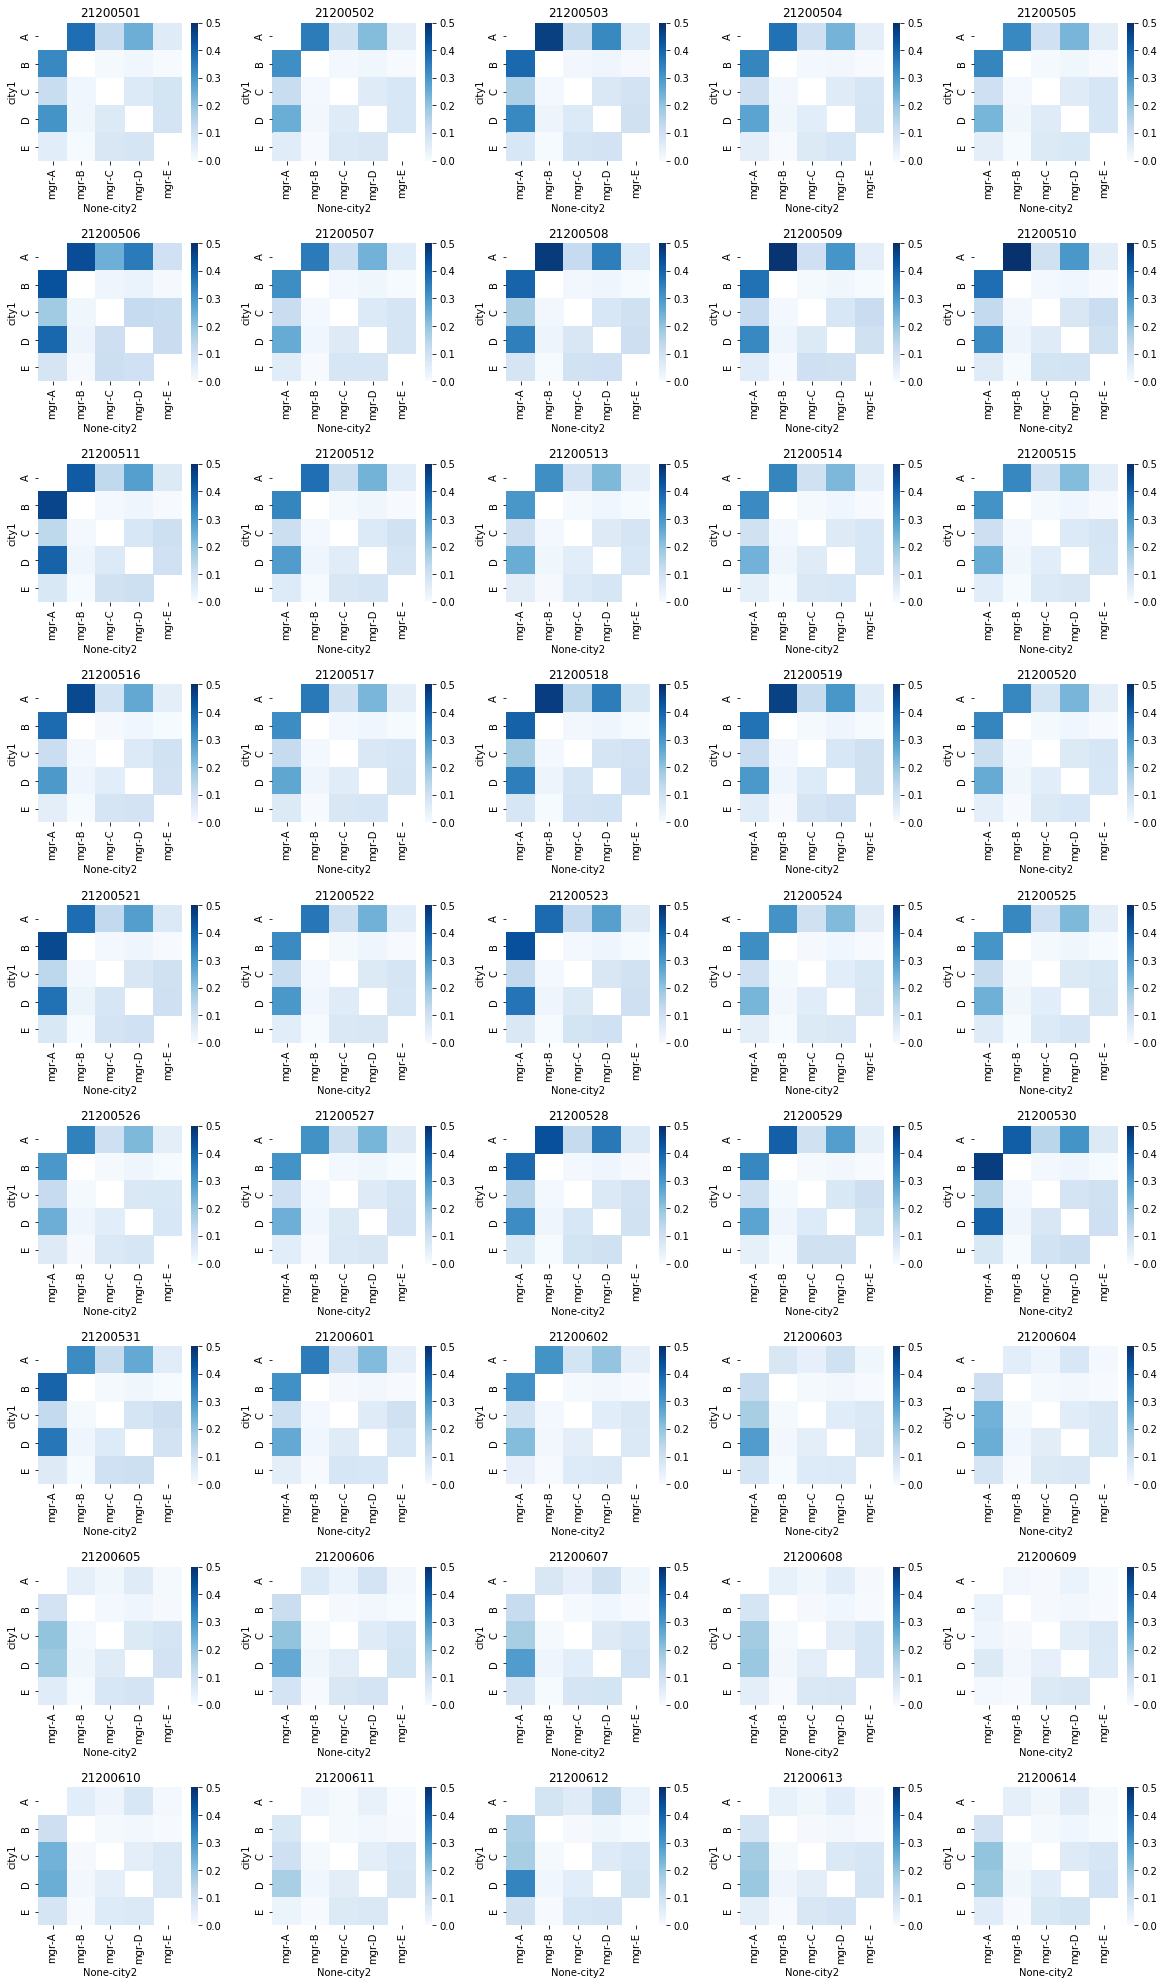

In [61]:
fig = plt.figure(figsize=(20,35))
plt.subplots_adjust(wspace =0.3, hspace =0.6)
dates=mgr.date.unique()
for i in range(len(dates)):
    date=dates[i]
    ax = fig.add_subplot(9, 5,i+1)
    ax.title.set_text('%s'%date)
    x=mgr[mgr.date==date].drop(columns='date').set_index(['city1','city2']).unstack()
    sns.heatmap(x,cmap='Blues',vmin=0, vmax=0.5,center=0.25)
fig.savefig('45天城市间迁徙指数.png',dpi=300, bbox_inches='tight')
plt.show()